In [1]:
# Models
# --------
# FBProphet
# Loader/fast aggregrations from: https://www.kaggle.com/christoffer/pandas-multi-indices-for-hts-fast-loading-etc

# FPBTD_v1 Level 9, LB=0.603
# yearly_seasonality=2 weekly_seasonality=1, n_changepoints = 50, LRMSE=12.128

# FPBTD_v2 - Levels 1 to 9
# yearly_seasonality=10 weekly_seasonality=3, n_changepoints = 50, US holidays added, LRMSE=11.824
# lag365, lag28_roll28 min and max

# FPBTD_v3 - Levels 1 to 5
# Same as previous with quarter_fourier_order=4, L6-L6=0.614

# FPBTD_v4 - Levels 1 to 9
# quarter_fourier_order=8 + cumulated price, L6-LB=0.616

# FPBTD_v5 - Levels 1 to 9
# quarter_fourier_order=6, outliers removed, L6-LB=0.637

# FPBTD_v6 - Levels 1 to 9
# quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.642

# FPBTD_v7 - Levels 1 to 9
# 2013, quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.61x

# FPBTD_v8 - Levels 1 to 9
# 2014, quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.63x

# FPBTD_v9 - Levels 1 to 9
# 2012, quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.618

# FPBTD_v10 - Levels 1 to 9
# 2012, quarter_fourier_order=6, additional lags, L6-LB=

In [2]:
import os, sys, random, gc, math, glob, time
import numpy as np
import pandas as pd
import io, timeit, os, gc, pickle, psutil
import joblib
from matplotlib import cm
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
from functools import partial
from collections import OrderedDict
# from tqdm.contrib.concurrent import process_map

# warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 4000)

In [3]:
seed = 2020
random.seed(seed)
np.random.seed(seed)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
DEFAULT_FIG_WIDTH = 20
sns.set_context("paper", font_scale=1.2) 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, ShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import csv
from collections import defaultdict

#import lightgbm as lgb

print('Python    : ' + sys.version.split('\n')[0])
print('Numpy     : ' + np.__version__)
print('Pandas    : ' + pd.__version__)
#print('LightGBM  : ' + lgb.__version__)

Python    : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy     : 1.18.1
Pandas    : 1.0.3


In [6]:
# !pip install fbprophet --upgrade

In [7]:
import fbprophet
from fbprophet import Prophet
print('Prophet  : ' + fbprophet.__version__)

Prophet  : 0.6


In [8]:
HOME =  "./"
DATA_HOME = "/kaggle/input/m5-forecasting-accuracy/"
TRAIN_DATA_HOME = DATA_HOME

CALENDAR = DATA_HOME + "calendar.csv"
SALES = DATA_HOME + "sales_train_validation.csv"
PRICES = DATA_HOME + "sell_prices.csv"

MODELS_DIR = "models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
            
NUM_SERIES = 30490
NUM_TRAINING = 1913
NUM_TEST = NUM_TRAINING + 2 * 28
MAX_LEVEL = 9 #9

In [9]:
# Load data
series_ids = np.empty(NUM_SERIES, dtype=object)
item_ids = np.empty(NUM_SERIES, dtype=object)
dept_ids = np.empty(NUM_SERIES, dtype=object)
cat_ids = np.empty(NUM_SERIES, dtype=object)
store_ids = np.empty(NUM_SERIES, dtype=object)
state_ids = np.empty(NUM_SERIES, dtype=object)

qties = np.zeros((NUM_TRAINING, NUM_SERIES), dtype=float)
sell_prices = np.zeros((NUM_TEST, NUM_SERIES), dtype=float)

In [10]:
# Sales
id_idx = {}
with open(SALES, "r", newline='') as f:
    is_header = True
    i = 0
    for row in csv.reader(f):
        if is_header:
            is_header = False
            continue
        series_id, item_id, dept_id, cat_id, store_id, state_id = row[0:6]
        # Remove '_validation/_evaluation' at end by regenerating series_id
        series_id = f"{item_id}_{store_id}"

        qty = np.array(row[6:], dtype=float)

        series_ids[i] = series_id

        item_ids[i] = item_id
        dept_ids[i] = dept_id
        cat_ids[i] = cat_id
        store_ids[i] = store_id
        state_ids[i] = state_id

        qties[:, i] = qty

        id_idx[series_id] = i

        i += 1

In [11]:
# Calendar
wm_yr_wk_idx = defaultdict(list)  # map wmyrwk to d:s
with open(CALENDAR, "r", newline='') as f:
    for row in csv.DictReader(f):
        d = int(row['d'][2:])
        wm_yr_wk_idx[row['wm_yr_wk']].append(d)

In [12]:
# Price
with open(PRICES, "r", newline='') as f:
    is_header = True
    for row in csv.reader(f):
        if is_header:
            is_header = False
            continue
        store_id, item_id, wm_yr_wk, sell_price = row
        series_id = f"{item_id}_{store_id}"
        series_idx = id_idx[series_id]
        for d in wm_yr_wk_idx[wm_yr_wk]:
            sell_prices[d - 1, series_idx] = float(sell_price)

In [13]:
# Aggregations - Levels
qty_ts = pd.DataFrame(qties,
                      index=range(1, NUM_TRAINING + 1),
                      columns=[state_ids, store_ids,
                               cat_ids, dept_ids, item_ids])

qty_ts.index.names = ['d']
qty_ts.columns.names = ['state_id', 'store_id',
                        'cat_id', 'dept_id', 'item_id']

price_ts = pd.DataFrame(sell_prices,
                        index=range(1, NUM_TEST + 1),
                        columns=[state_ids, store_ids,
                                 cat_ids, dept_ids, item_ids])
price_ts.index.names = ['d']
price_ts.columns.names = ['state_id', 'store_id',
                          'cat_id', 'dept_id', 'item_id']

In [14]:
LEVELS = {
    1: [],
    2: ['state_id'],
    3: ['store_id'],
    4: ['cat_id'],
    5: ['dept_id'],
    6: ['state_id', 'cat_id'],
    7: ['state_id', 'dept_id'],
    8: ['store_id', 'cat_id'],
    9: ['store_id', 'dept_id'],
    10: ['item_id'],
    11: ['state_id', 'item_id'],
    12: ['item_id', 'store_id']
}

COARSER = {
    'state_id': [],
    'store_id': ['state_id'],
    'cat_id': [],
    'dept_id': ['cat_id'],
    'item_id': ['cat_id', 'dept_id']
}

In [15]:
def aggregate_all_levels(df):
    levels = []
    for i in range(1, max(LEVELS.keys()) + 1):
        level = aggregate_groupings(df, i, *LEVELS[i])
        levels.append(level)
    return pd.concat(levels, axis=1)

def aggregate_groupings(df, level_id, grouping_a=None, grouping_b=None):
    """Aggregate time series by summing over optional levels

    New columns are named according to the m5 competition.

    :param df: Time series as columns
    :param level_id: Numeric ID of level
    :param grouping_a: Grouping to aggregate over, if any
    :param grouping_b: Additional grouping to aggregate over, if any
    :return: Aggregated DataFrame with columns as series id:s
    """
    if grouping_a is None and grouping_b is None:
        new_df = df.sum(axis=1).to_frame()
    elif grouping_b is None:
        new_df = df.groupby(COARSER[grouping_a] + [grouping_a], axis=1).sum()
    else:
        assert grouping_a is not None
        new_df = df.groupby(COARSER[grouping_a] + COARSER[grouping_b] +
                            [grouping_a, grouping_b], axis=1).sum()

    new_df.columns = _restore_columns(df.columns, new_df.columns, level_id,
                                      grouping_a, grouping_b)
    return new_df

In [16]:
def _restore_columns(original_index, new_index, level_id, grouping_a, grouping_b):
    original_df = original_index.to_frame()
    new_df = new_index.to_frame()
    for column in original_df.columns:
        if column not in new_df.columns:
            new_df[column] = None

    # Set up `level` column
    new_df['level'] = level_id

    # Set up `id` column
    if grouping_a is None and grouping_b is None:
        new_df['id'] = 'Total_X'
    elif grouping_b is None:
        new_df['id'] = new_df[grouping_a] + '_X'
    else:
        assert grouping_a is not None
        new_df['id'] = new_df[grouping_a] + '_' + new_df[grouping_b]

    new_index = pd.MultiIndex.from_frame(new_df)
    # Remove "unnamed" level if no grouping
    if grouping_a is None and grouping_b is None:
        new_index = new_index.droplevel(0)
    new_levels = ['level'] + original_index.names + ['id']
    return new_index.reorder_levels(new_levels)

In [17]:
agg_pd = aggregate_all_levels(qty_ts)
agg_pd.head()

level          1        2                       3                           \
state_id      NaN       CA      TX      WI      CA                           
store_id      NaN      NaN     NaN     NaN    CA_1    CA_2    CA_3    CA_4   
cat_id        NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
dept_id       NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
item_id       NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
id        Total_X     CA_X    TX_X    WI_X  CA_1_X  CA_2_X  CA_3_X  CA_4_X   
d                                                                            
1         32631.0  14195.0  9438.0  8998.0  4337.0  3494.0  4739.0  1625.0   
2         31749.0  13805.0  9630.0  8314.0  4155.0  3046.0  4827.0  1777.0   
3         23783.0  10108.0  6778.0  6897.0  2816.0  2121.0  3785.0  1386.0   
4         25412.0  11047.0  7381.0  6984.0  3051.0  2324.0  4232.0  1440.0   
5         19146.0   9925.0  5912.0  3309.0  2630.0  1942.0  3817.0  1536.0   

level                                                          4             \
state_id      TX                      WI                      NaN             
store_id    TX_1    TX_2    TX_3    WI_1    WI_2    WI_3      NaN             
cat_id       NaN     NaN     NaN     NaN     NaN     NaN    FOODS   HOBBIES   
dept_id      NaN     NaN     NaN     NaN     NaN     NaN      NaN       NaN   
item_id      NaN     NaN     NaN     NaN     NaN     NaN      NaN       NaN   
id        TX_1_X  TX_2_X  TX_3_X  WI_1_X  WI_2_X  WI_3_X  FOODS_X HOBBIES_X   
d                                                                             
1         2556.0  3852.0  3030.0  2704.0  2256.0  4038.0  23178.0    3764.0   
2         2687.0  3937.0  3006.0  2194.0  1922.0  4198.0  22758.0    3357.0   
3         1822.0  2731.0  2225.0  1562.0  2018.0  3317.0  17174.0    2682.0   
4         2258.0  2954.0  2169.0  1251.0  2522.0  3211.0  18878.0    2669.0   
5         1694.0  2492.0  1726.0     2.0  1175.0  2132.0  14603.0    1814.0   

level                       5                                               \
state_id                   NaN                                               
store_id                   NaN                                               
cat_id     HOUSEHOLD     FOODS                         HOBBIES               
dept_id          NaN   FOODS_1   FOODS_2   FOODS_3   HOBBIES_1   HOBBIES_2   
item_id          NaN       NaN       NaN       NaN         NaN         NaN   
id       HOUSEHOLD_X FOODS_1_X FOODS_2_X FOODS_3_X HOBBIES_1_X HOBBIES_2_X   
d                                                                            
1             5689.0    2343.0    4094.0   16741.0      3610.0       154.0   
2             5634.0    2216.0    4209.0   16333.0      3172.0       185.0   
3             3927.0    1657.0    3174.0   12343.0      2497.0       185.0   
4             3865.0    1508.0    3606.0   13764.0      2531.0       138.0   
5             2729.0    1209.0    2869.0   10525.0      1714.0       100.0   

level                                      6                           \
state_id                                   CA                           
store_id                                  NaN                           
cat_id       HOUSEHOLD                  FOODS    HOBBIES    HOUSEHOLD   
dept_id    HOUSEHOLD_1   HOUSEHOLD_2      NaN        NaN          NaN   
item_id            NaN           NaN      NaN        NaN          NaN   
id       HOUSEHOLD_1_X HOUSEHOLD_2_X CA_FOODS CA_HOBBIES CA_HOUSEHOLD   
d                                                                       
1               4105.0        1584.0  10101.0     1802.0       2292.0   
2               3858.0        1776.0   9862.0     1561.0       2382.0   
3               2827.0        1100.0   6944.0     1472.0       1692.0   
4               2732.0        1133.0   7864.0     1405.0       1778.0   
5               1802.0         927.0   7178.0     1181.0       156

In [18]:
# All levels
df_train = agg_pd.T.reset_index()
df_train = df_train.set_index("id") # id as index
rename_dict = {}
for c in df_train.columns:
    if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']:
        rename_dict[c] = "d_%s" % c
df_train.rename(columns=rename_dict, inplace=True)
day_cols = pd.Series([c for c in df_train.columns if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']]) # d_1 to d_1913
print(df_train.shape)
df_train.head()

(42840, 1919)


d        level state_id store_id cat_id dept_id item_id      d_1      d_2  \
id                                                                          
Total_X      1      NaN      NaN    NaN     NaN     NaN  32631.0  31749.0   
CA_X         2       CA      NaN    NaN     NaN     NaN  14195.0  13805.0   
TX_X         2       TX      NaN    NaN     NaN     NaN   9438.0   9630.0   
WI_X         2       WI      NaN    NaN     NaN     NaN   8998.0   8314.0   
CA_1_X       3       CA     CA_1    NaN     NaN     NaN   4337.0   4155.0   

d            d_3      d_4      d_5      d_6      d_7      d_8      d_9  \
id                                                                       
Total_X  23783.0  25412.0  19146.0  29211.0  28010.0  37932.0  32736.0   
CA_X     10108.0  11047.0   9925.0  11322.0  12251.0  16610.0  14696.0   
TX_X      6778.0   7381.0   5912.0   9006.0   6226.0   9440.0   9376.0   
WI_X      6897.0   6984.0   3309.0   8883.0   9533.0  11882.0   8664.0   
CA_1_X    2816.0   3051.0   2630.0   3276.0   3450.0   5437.0   4340.0   

d           d_10     d_11     d_12     d_13     d_14     d_15     d_16  \
id                                                                       
Total_X  25572.0  23071.0  23658.0  23756.0  26445.0  34833.0  36380.0   
CA_X     11822.0  10933.0  10350.0  11204.0  11354.0  14610.0  15630.0   
TX_X      7319.0   6224.0   6740.0   6109.0   7202.0  10081.0  11725.0   
WI_X      6431.0   5914.0   6568.0   6443.0   7889.0  10142.0   9025.0   
CA_1_X    3157.0   2995.0   2710.0   2928.0   3078.0   4316.0   4354.0   

d           d_17     d_18     d_19     d_20     d_21     d_22     d_23  \
id                                                                       
Total_X  21804.0  24070.0  21443.0  20318.0  23721.0  31689.0  29283.0   
CA_X      9044.0   9496.0   8844.0   7835.0  10025.0  13870.0  13465.0   
TX_X      6719.0   7460.0   6606.0   6412.0   6711.0   9150.0   9789.0   
WI_X      6041.0   7114.0   5993.0   6071.0   6985.0   8669.0   6029.0   
CA_1_X    2757.0   2430.0   2272.0   2009.0   3015.0   4553.0   3966.0   

d           d_24     d_25     d_26     d_27     d_28     d_29     d_30  \
id                                                                       
Total_X  23966.0  20501.0  20757.0  20277.0  22529.0  29908.0  28707.0   
CA_X     11997.0   9130.0   8941.0   8514.0   9847.0  13652.0  12491.0   
TX_X      7297.0   6628.0   5814.0   6175.0   6286.0   8586.0   9086.0   
WI_X      4672.0   4743.0   6002.0   5588.0   6396.0   7670.0   7130.0   
CA_1_X    3264.0   2441.0   2377.0   2414.0   2701.0   3719.0   3548.0   

d           d_31     d_32     d_33     d_34     d_35     d_36     d_37  \
id                                                                       
Total_X  21240.0  22872.0  22046.0  23475.0  23572.0  31202.0  34876.0   
CA_X      9196.0   9782.0   9537.0   9710.0  10444.0  13784.0  16057.0   
TX_X      6555.0   7082.0   6145.0   6639.0   6584.0   9238.0  10423.0   
WI_X      5489.0   6008.0   6364.0   7126.0   6544.0   8180.0   8396.0   
CA_1_X    2246.0   2549.0   2559.0   2568.0   2978.0   4096.0   4832.0   

d           d_38     d_39     d_40     d_41     d_42     d_43     d_44  \
id                                                                       
Total_X  24562.0  22752.0  22560.0  22626.0  25572.0  32225.0  31417.0   
CA_X     10953.0  10299.0   9951.0  10012.0  11189.0  13710.0  14340.0   
TX_X      7623.0   6335.0   6941.0   6339.0   7203.0   9271.0   9542.0   
WI_X      5986.0   6118.0   5668.0   6275.0   7180.0   9244.0   7535.0   
CA_1_X    3138.0   2997.0   2772.0   2650.0   3249.0   4114.0   4094.0   

d           d_45     d_46     d_47     d_48     d_49     d_50     d_51  \
id                                                                       
Total_X  24935.0  24021.0  22765.0  21779.0  23855.0  30599.0  29643.0   
CA_X     10722.0   9293.0   9752.0   9504.0  10030.0  14509.0  14112.0   
TX_X      7745.0   7834.0   6768.0   6759.0   7131

In [19]:
# agg_price_pd = aggregate_all_levels(price_ts)
# agg_price_pd.head()

In [20]:
# df_train_price = agg_price_pd.T.reset_index()
# df_train_price = df_train_price.set_index("id") # id as index
# rename_dict = {}
# for c in df_train_price.columns:
#     if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']:
#         rename_dict[c] = "d_%s" % c
# df_train_price.rename(columns=rename_dict, inplace=True)
# day_prices_cols = pd.Series([c for c in df_train_price.columns if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']]) # d_1 to d_1913+
# print(df_train_price.shape)
# df_train_price.head()

In [21]:
# Level 12 only
df_sale = df_train[df_train["level"] == 12]
df_sale.shape

(30490, 1919)

In [22]:
# Levels <= 9
df_train = df_train[df_train["level"] <= MAX_LEVEL]
print(df_train.shape)

(154, 1919)


In [23]:
# df_train_price = df_train_price[df_train_price["level"] <= MAX_LEVEL]
# print(df_train_price.shape)

Prepare data for Prophet

In [24]:
# Prepare calendar columns
df_calendar = pd.read_csv(CALENDAR)
df_calendar.index = df_calendar['d'].values # d_xxx as index
df_calendar['ds'] = pd.to_datetime(df_calendar['date']) # move date as datetime in "ds" column
df_calendar['quarter'] = df_calendar['ds'].dt.quarter # add quarter feature
df_calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
d_1  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
d_2  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
d_3  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
d_4  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
d_5  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

    event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  \
d_1          NaN          NaN          NaN        0        0        0   
d_2          NaN          NaN          NaN        0        0        0   
d_3          NaN          NaN          NaN        0        0        0   
d_4          NaN          NaN          NaN        1        1        0   
d_5          NaN          NaN          NaN        1        0        1   

            ds  quarter  
d_1 2011-01-29        1  
d_2 2011-01-30        1  
d_3 2011-01-31        1  
d_4 2011-02-01        1  
d_5 2011-02-02        1

In [25]:
# Generate holidays ds
events1 = pd.Series(df_calendar['event_name_1'].values, index=df_calendar['ds'].values).dropna()
events2 = pd.Series(df_calendar['event_name_2'].values, index=df_calendar['ds'].values).dropna()
holidays = pd.DataFrame(pd.concat([events1, events2], axis=0))
holidays['ds'] = holidays.index.values
holidays.rename({0: 'holiday'}, axis=1, inplace=True)
holidays.reset_index(drop=True, inplace=True)
del events1, events2
holidays.head()

holiday         ds
0      SuperBowl 2011-02-06
1  ValentinesDay 2011-02-14
2  PresidentsDay 2011-02-21
3      LentStart 2011-03-09
4      LentWeek2 2011-03-16

In [26]:
# Clean data: remove leading zeros and outliers
def clean_data(df_train, day_cols, indx):
    t = df_train.loc[indx].copy()
    t.loc[day_cols[((t.loc[day_cols]>0).cumsum()==0).values]] = np.nan
    q1 = t.loc[day_cols].quantile(0.25)
    q3 = t.loc[day_cols].quantile(0.75)
    iqr = q3-q1
    qm = (q3+1.5*iqr)
    t.loc[day_cols][t.loc[day_cols]>qm] = qm
    return t

In [27]:
future_preds = 28
day_fit_cols = day_cols

In [28]:
# Remove noticeable dates that are not in evaluation
ignore_dates = ["2011-12-25", "2012-12-25", "2013-12-25", "2014-12-25", "2015-12-25",
                "2011-12-24", "2012-12-24", "2013-12-24", "2014-12-24", "2015-12-24",
                "2011-12-31", "2012-12-31", "2013-12-31", "2014-12-31", "2015-12-31",
                "2012-01-01", "2013-01-01", "2014-01-01", "2015-01-01", "2016-01-01"]
ignore_days = [] # df_calendar[df_calendar['ds'].isin(ignore_dates)]["d"].apply(lambda x: int(x[2:])).values

In [29]:
FIRST = 338 # 1069 # 704 # 1 # 704
day_fit_cols = ["d_%d"%c for c in range(FIRST, 1914) if c not in ignore_days]
df_train = df_train[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'level'] + day_fit_cols]
df_calendar = df_calendar[df_calendar["d"].isin(["d_%d"%c for c in range(FIRST, 1942) if c not in ignore_days])]
#df_prices = df_prices[["d_%d"%c for c in range(FIRST, 1942) if c not in ignore_days]]

In [30]:
# df_train: "id" ["d_1", "d_2", ...]
# holidays: ["holiday", "ds"]
# df_calendar d ["date", "ds", "weekday", "wday", "month", "year", "quarter" ...]
# df_prices: "id" ["d_1", "d_2", ...]
def make_prediction(indx, model_columns = 'yhat', ret_columns = 'yhat', full_predict = True):
    global df_train, holidays, df_calendar # df_train_price, df_prices
    # full_predict = True
    # Return either series or dataframe
    # model_columns = 'yhat' # ["yhat", "yhat_lower", "yhat_upper"]  # 'yhat' ["yhat"]
    # ret_columns = model_columns # + ["ds", "y"]
    changepoints=list()
    uncertainty_samples=False # False (True to include yhat_upper ...)
    changepoint_prior_scale=0.1
    changepoint_range=0.9
    n_changepoints=50
    holidays_prior_scale=10
    yearly_seasonality=10 #2
    weekly_seasonality=3 #1
    daily_seasonality=False
    monthly_fourier_order=8
    quarter_fourier_order=6 # 6 #None
    seasonality_prior_scale=10
    seasonality_mode = 'multiplicative'  # 'additive'
    
    target = df_train.loc[indx, day_fit_cols] # sales for one time series
    # target_price = df_train_price.loc[indx, day_prices_cols] # day_fit_cols

    snap_state_id = str(df_train.loc[indx, 'state_id'])
    cols = ['ds', 'month', 'wday', 'quarter']
    if snap_state_id in ["CA", "TX", "WI"]:
        cols = cols + ['snap_'+snap_state_id]

    # Create temporary dataframe for prediction from 2011-01-29	to 2016-05-22 (d_1941) initialized with NaN for values to predict
    # ["ds", "y", "prices", "month", "wday", "quarter", "snap_xx"] (snap matching to state related to id)
    df = df_calendar.iloc[:target.shape[0]+future_preds][cols].copy()
    df['y'] = target    
    
    # Clip outliers in aggregated time series
    #q1 = df['y'].quantile(0.25)
    #q3 = df['y'].quantile(0.75)
    #iqr = q3-q1
    #qm_up = (q3+1.5*iqr)
    #qm_dw = (q1-1.5*iqr)
    #df.loc[df["y"] > qm_up, "y"] = qm_up
    #df.loc[df["y"] < qm_dw, "y"] = qm_dw
    
    #df['ft_lag365'] = df['y'].shift(365)
    #df["ft_lag365"].fillna(method ='bfill', inplace = True)
    df['ft_lag28'] = df['y'].shift(28)
    df["ft_lag28"].fillna(method ='bfill', inplace = True)
    df['ft_lag35'] = df['y'].shift(35)
    df["ft_lag35"].fillna(method ='bfill', inplace = True)
    df['ft_lag42'] = df['y'].shift(42)
    df["ft_lag42"].fillna(method ='bfill', inplace = True)
    df['ft_lag28_roll28_std'] = df['y'].shift(28).rolling(28).std()
    df["ft_lag28_roll28_std"].fillna(method ='bfill', inplace = True)
    df['ft_lag28_roll28_max'] = df['y'].shift(28).rolling(28).max()
    df["ft_lag28_roll28_max"].fillna(method ='bfill', inplace = True)
    df['ft_lag28_roll28_min'] = df['y'].shift(28).rolling(28).min()
    df["ft_lag28_roll28_min"].fillna(method ='bfill', inplace = True)
    # Add prices
    #df['prices'] = target_price.astype(np.float32)
    #df["prices"].fillna(method ='bfill', inplace = True)
    #df['ft_prices_roll7_std'] = df['prices'].rolling(7).std()
    #df["ft_prices_roll7_std"].fillna(method ='bfill', inplace = True)    

    GROWTH = 'linear' #'logistic' #'linear'
    m = Prophet(growth=GROWTH, uncertainty_samples=uncertainty_samples, changepoint_prior_scale=changepoint_prior_scale, changepoint_range=changepoint_range,
                n_changepoints = n_changepoints,
                holidays_prior_scale=holidays_prior_scale, yearly_seasonality=yearly_seasonality,
                daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality,
                holidays=holidays, seasonality_mode=seasonality_mode, seasonality_prior_scale=seasonality_prior_scale)
    
    m.add_country_holidays(country_name='US')

    if not monthly_fourier_order is None:
        m.add_seasonality(name='monthly', period=365.25/12, fourier_order=monthly_fourier_order)
    if not quarter_fourier_order is None:
        m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=quarter_fourier_order)

    # Add regressor for month, wday, quarter (snap_XX, prices)
    for reg in df.columns:
        if reg!='ds' and reg!='y':
            m.add_regressor(reg)

    target_first_valid_index = target.first_valid_index()

    if GROWTH == "logistic":
        df["cap"] = df["y"].max()
        df["floor"] = df["y"].min()
        
    # Fit on existing data (first_valid_index = Return index for first non-NA/null value.)
    m.fit(df.loc[target.loc[target_first_valid_index:].index])

    # Remove target
    if 'y' not in ret_columns:
        df.drop(['y'], axis=1, inplace=True)

    res = None
    if full_predict == True:
        forecast = m.predict(df.loc[target_first_valid_index:]) # For all days with valid data
        forecast["yhat"] = forecast["yhat"].astype(np.float32)
        res = forecast[model_columns]
        # Update prediction from first valid index from 2016-05-22
        res.index = df.loc[target_first_valid_index:].index.values
        res = df.merge(res, left_index=True, right_index=True, how="left")[ret_columns]

    else:
        forecast = m.predict(df.iloc[-future_preds:]) # for last 28 days (2016-04-25 to 2016-05-22)
        forecast["yhat"] = forecast["yhat"].astype(np.float32)
        res = forecast[model_columns]
        # Update prediction index from d_1914 to d_1941
        res.index = df.iloc[-future_preds:].index.values

    return (indx, res)

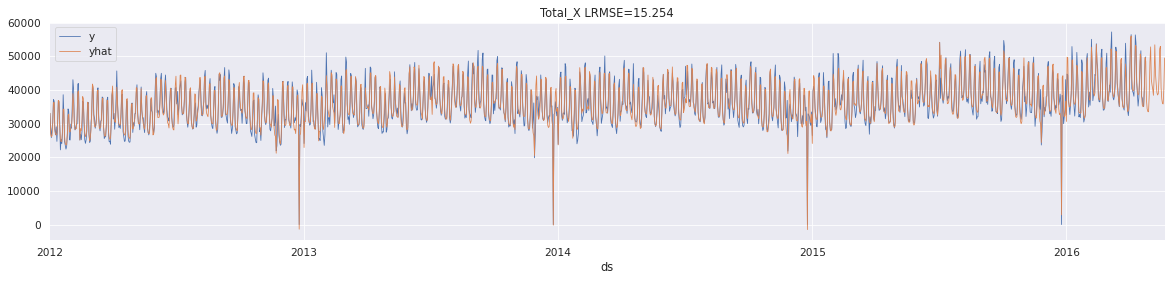

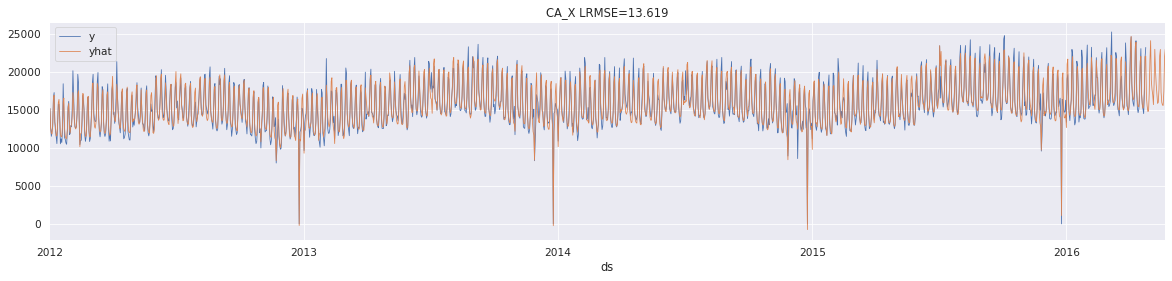

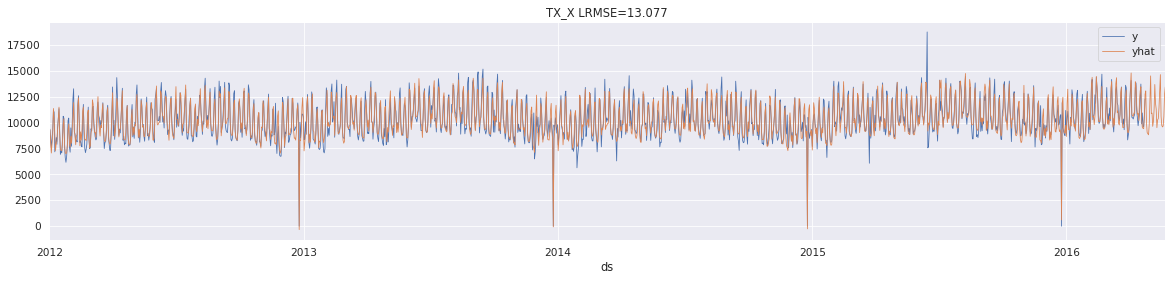

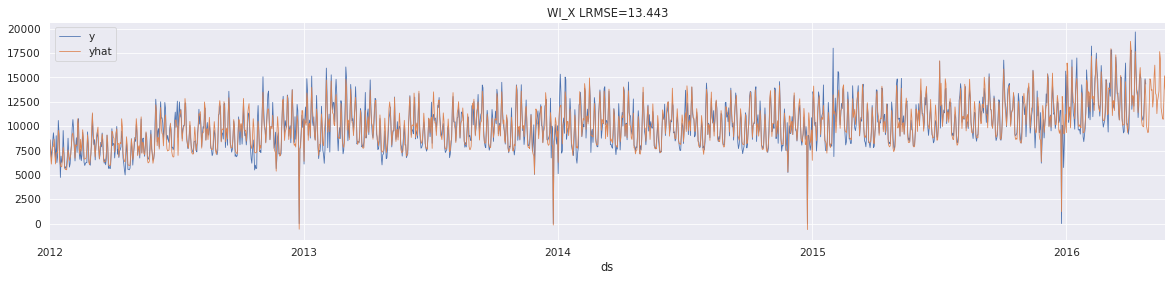

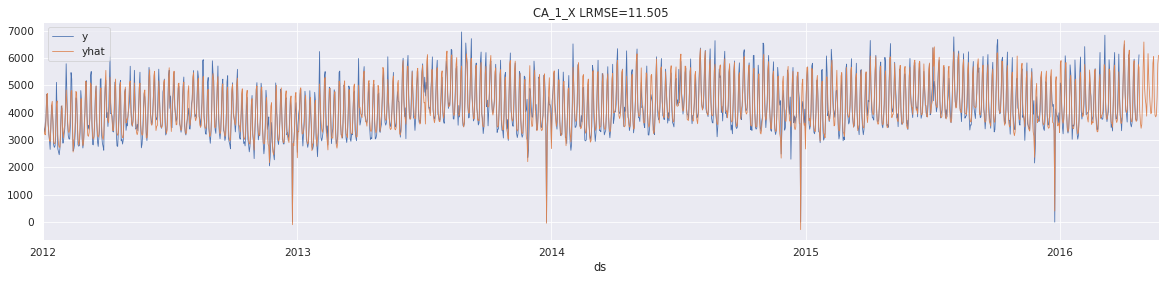

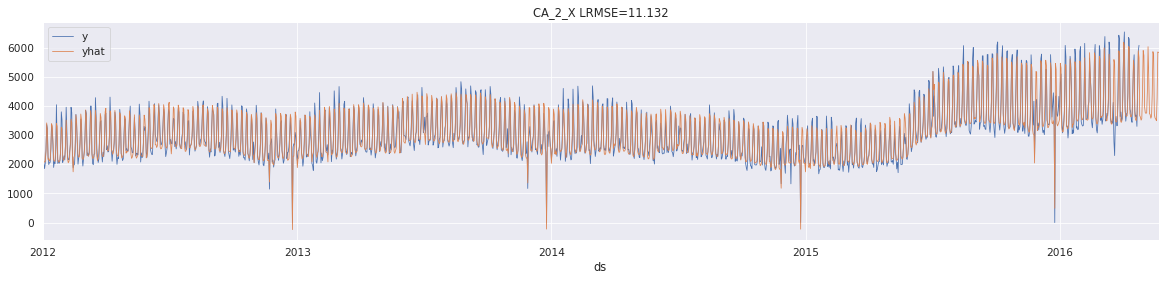

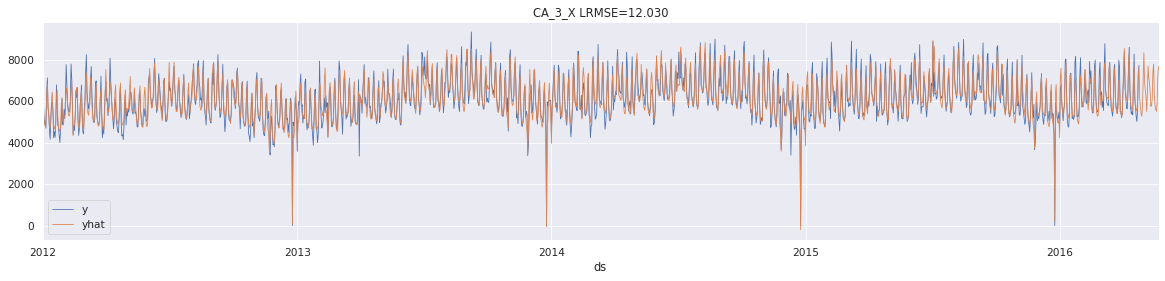

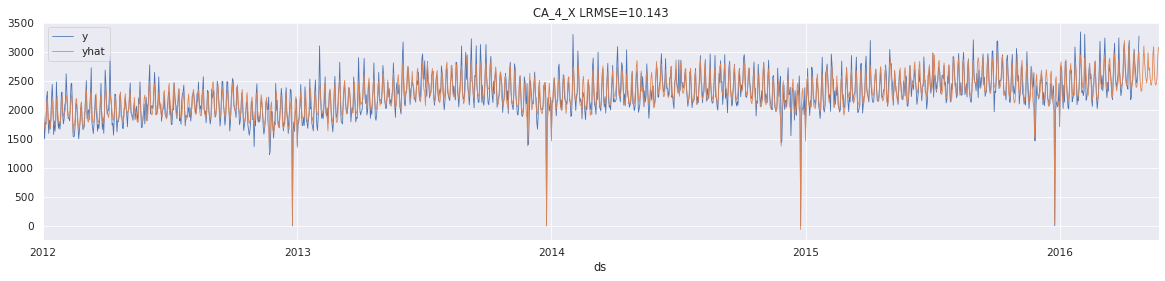

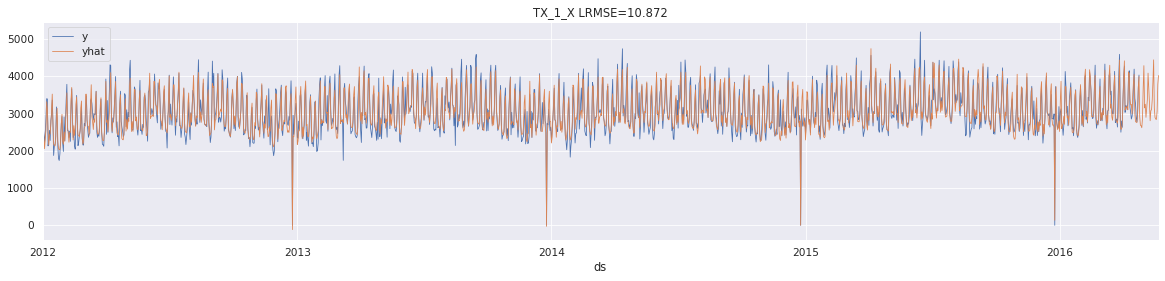

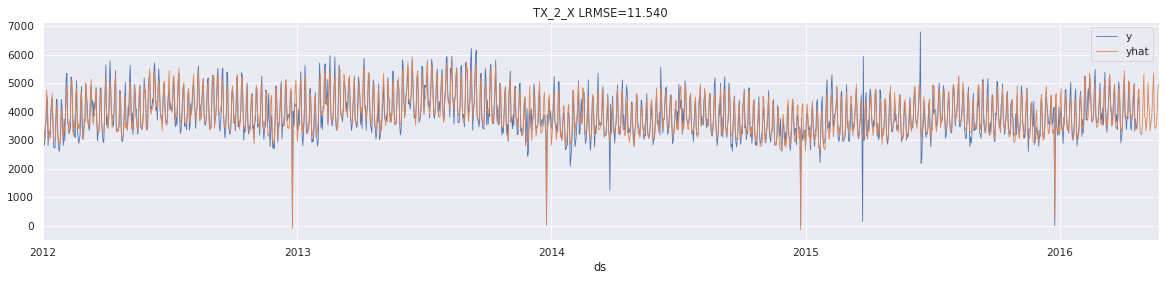

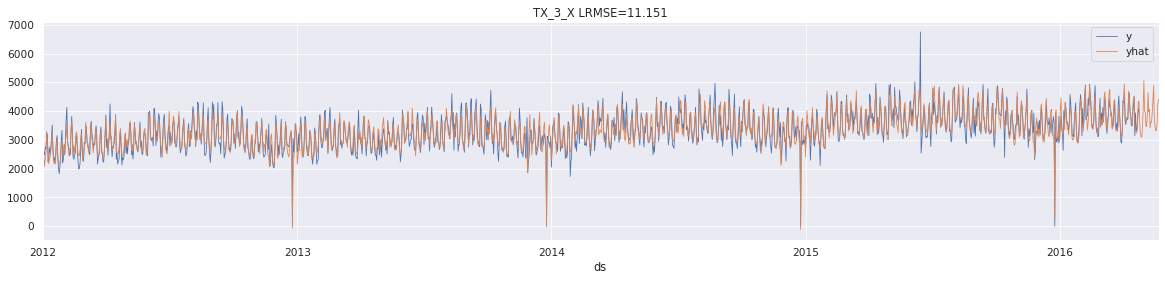

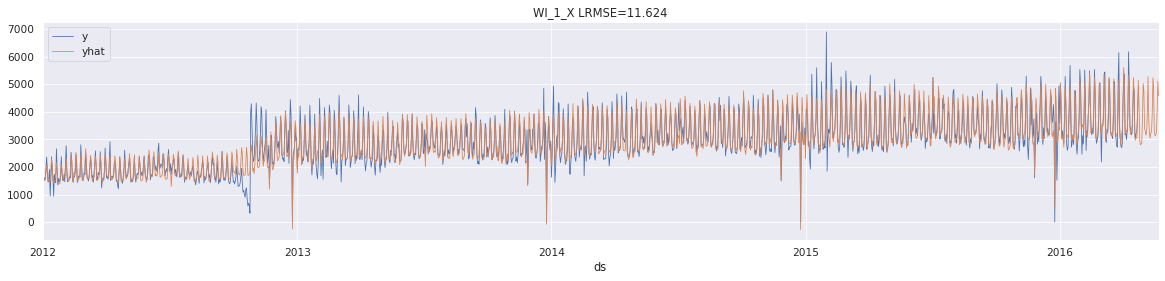

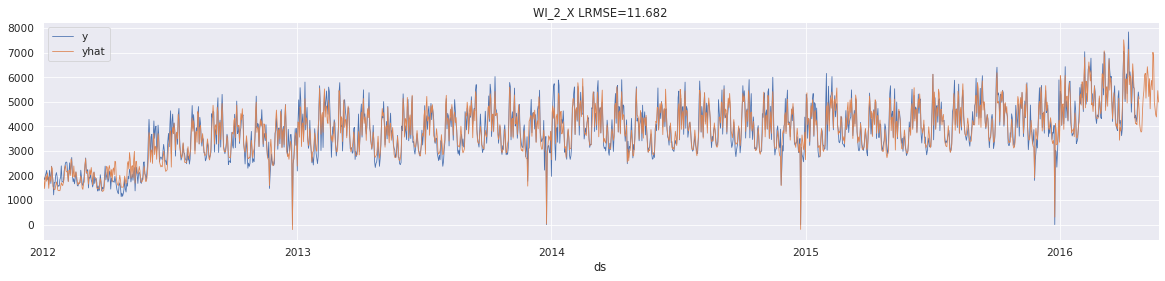

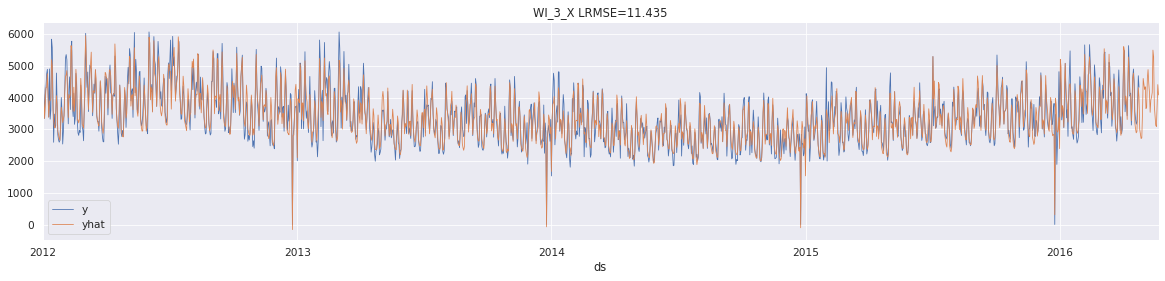

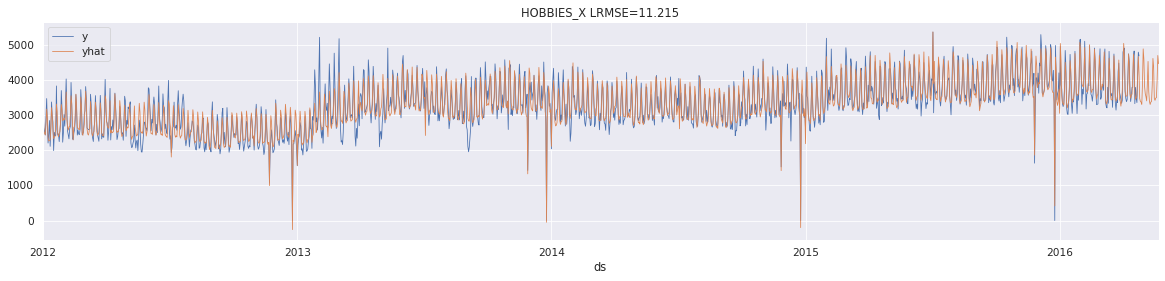

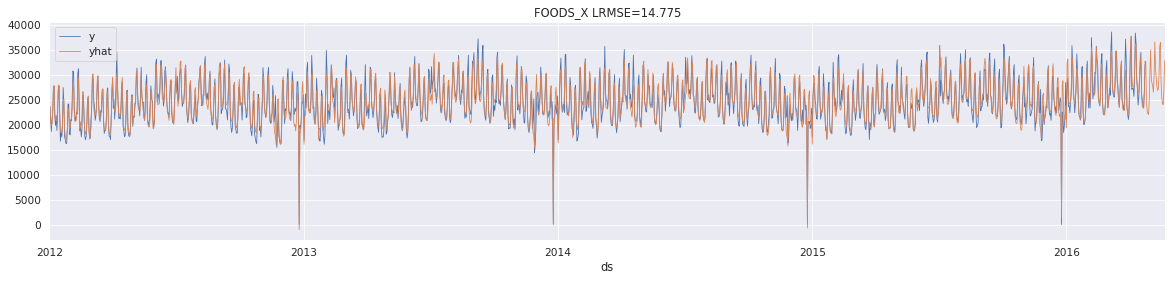

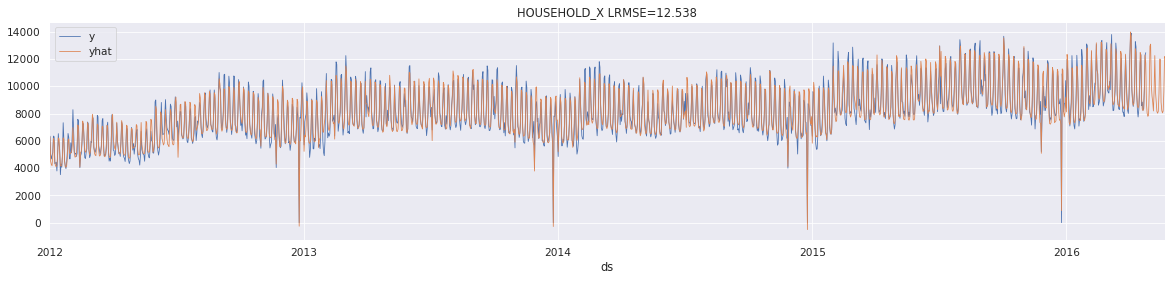

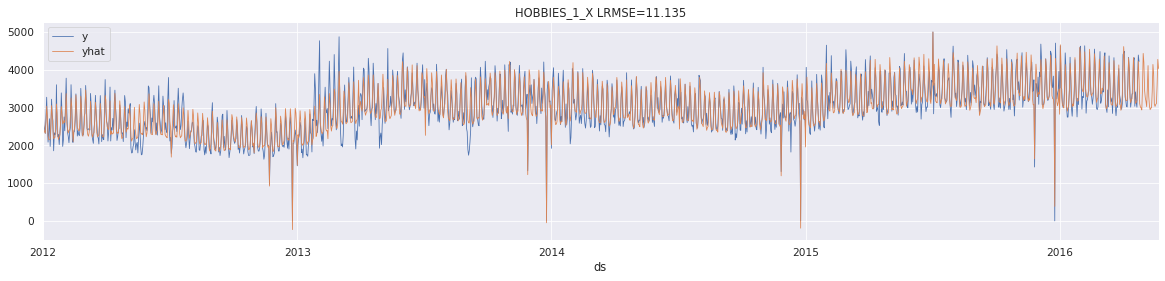

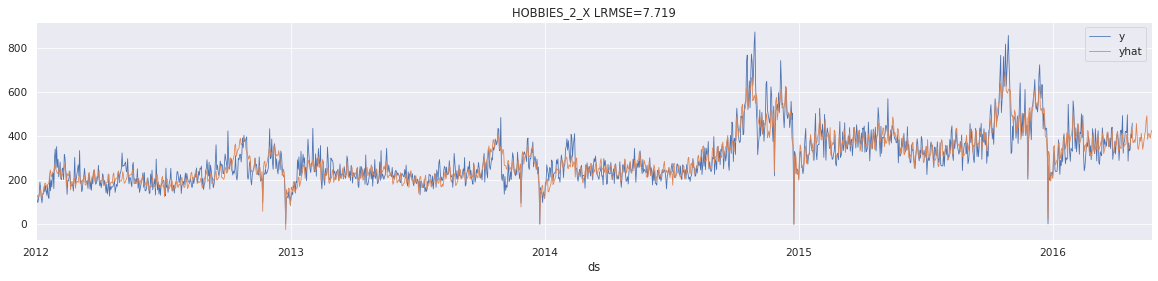

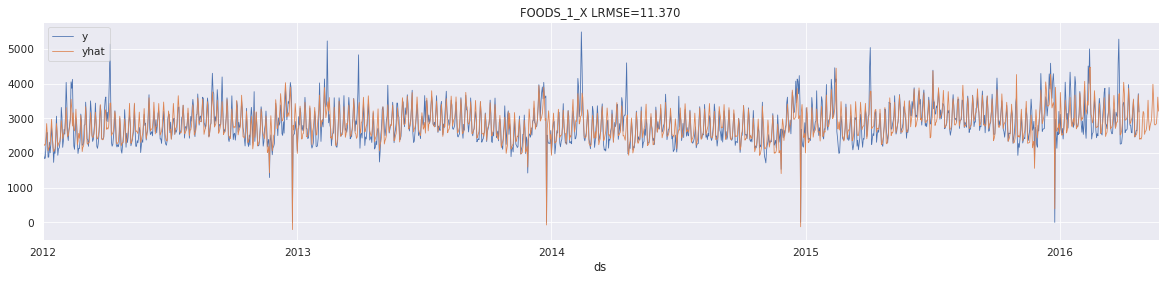

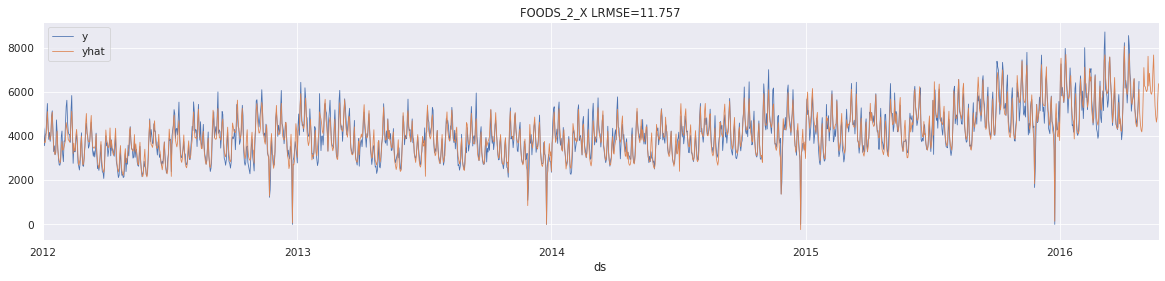

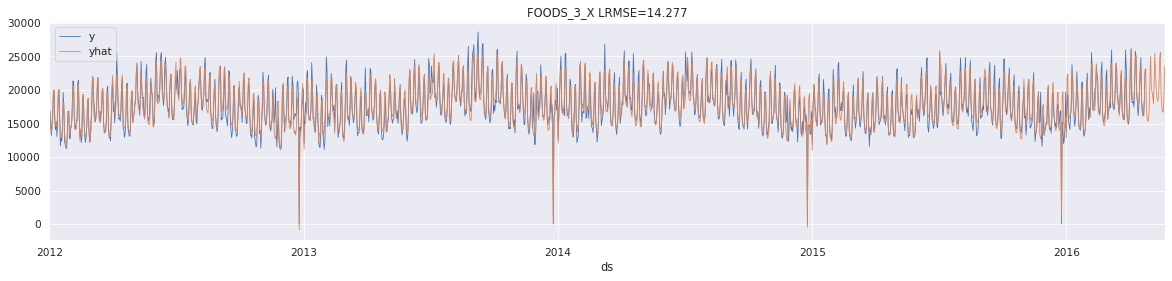

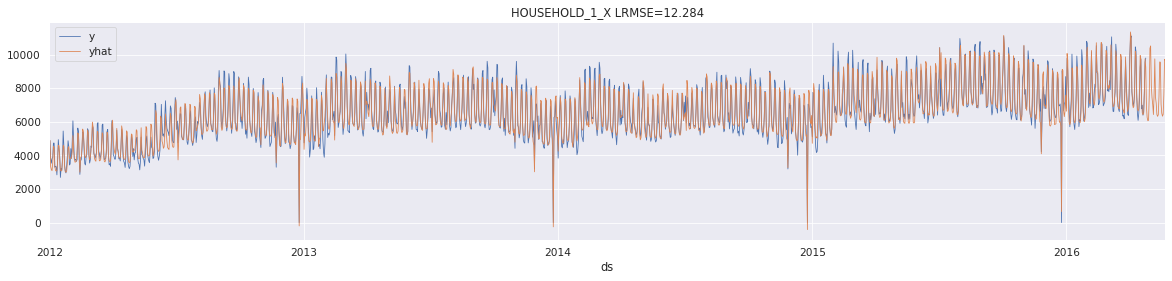

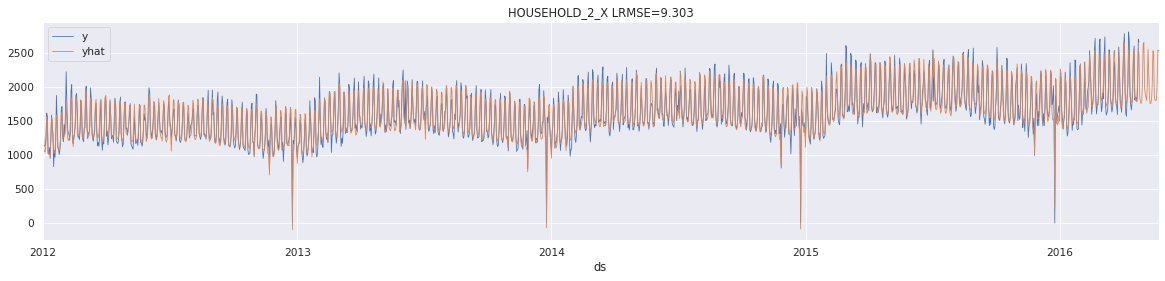

Average LRMSE=11.870


In [31]:
# Basic EDA and hyperparameters tuning
# model_columns = ['yhat']
# ret_columns = model_columns + ["ds", "y"]

train_indxs = ["Total_X"] # L1
train_indxs = train_indxs + ["CA_X", "TX_X", "WI_X"] # L2
train_indxs = train_indxs + ['CA_1_X', 'CA_2_X', 'CA_3_X','CA_4_X', 'TX_1_X', 'TX_2_X', 'TX_3_X', 'WI_1_X', 'WI_2_X', 'WI_3_X'] # L3
train_indxs = train_indxs + ['HOBBIES_X', 'FOODS_X', 'HOUSEHOLD_X'] # L4
train_indxs = train_indxs + ['HOBBIES_1_X', 'HOBBIES_2_X', 'FOODS_1_X', 'FOODS_2_X', 'FOODS_3_X', 'HOUSEHOLD_1_X', 'HOUSEHOLD_2_X'] # L5

m_score = 0
for train_ind in train_indxs:
    (_, pred) = make_prediction(train_ind, model_columns = ['yhat'], ret_columns = ['yhat', 'ds', 'y']) # 'prices'
    fig, ax = plt.subplots(figsize=(DEFAULT_FIG_WIDTH, 4))
    d = pred.set_index("ds").plot(kind="line", y=["y", "yhat"], ax=ax, linestyle='-', linewidth=0.8) # 'prices'
    score = np.log1p(mean_squared_error(pred["y"][:-28], pred["yhat"][:-28]))
    m_score = m_score + (score / len(train_indxs))
    plt.title("%s LRMSE=%.3f" % (train_ind, score))
    plt.show()
    #break
print("Average LRMSE=%.3f" % m_score)

In [32]:
print('Predicting...', flush=True)
start_time = time.time()
#pool = Pool()

train_indxs = df_train.index #[0:10]

# Memory crash with multiple CPU on Kaggle
# res = pool.map(make_prediction, train_indxs)
# res = process_map(make_prediction, train_indxs, chunksize=1)
res = []
for train_indx in tqdm(train_indxs):
    r = make_prediction(train_indx)
    res.append(r)
    
#pool.close()
#pool.join()
end_time = time.time()
print('Exec speed=%.2f' %((end_time-start_time)/train_indxs.shape[0]))

Predicting...



Exec speed=3.64


In [33]:
# Convert back to initial format
tmp = pd.DataFrame()
for result in res:
    uid = result[0]
    ret = result[1].rename(uid)
    tmp = pd.concat([tmp, ret], axis=1)
fbp_pd = tmp.T
fbp_pd.index.name = "id"
fbp_pd.head(10)

d_338         d_339         d_340         d_341         d_342  \
id                                                                              
Total_X  28634.144531  33070.746094  26942.947266  26127.996094  26338.275391   
CA_X     13629.899414  15170.422852  12522.043945  11938.539062  11804.191406   
TX_X      9552.464844   9304.648438   8052.095215   7058.568359   7936.913574   
WI_X      5678.021973   8608.769531   7167.301270   6107.763672   7015.158691   
CA_1_X    3794.058105   3935.875244   3434.406738   3226.395264   3188.080078   
CA_2_X    2942.463623   2978.709473   2101.414062   2073.001221   2103.979736   
CA_3_X    5209.419922   6205.999512   5139.820801   4894.036133   4786.750977   
CA_4_X    1662.897095   2039.875854   1787.598145   1685.733765   1667.553223   
TX_1_X    2955.528564   2750.921387   2317.581787   2055.375977   2340.543701   
TX_2_X    3993.635254   3724.993652   3315.295654   2931.570801   3283.567871   

                d_343         d_344         d_345         d_346         d_347  \
id                                                                              
Total_X  29895.232422  36227.832031  36321.382812  28549.261719  26988.882812   
CA_X     13197.535156  16501.646484  16907.003906  13360.791992  12741.511719   
TX_X      8850.335938  11356.167969  10346.414062   8766.581055   7273.663086   
WI_X      7878.296875   7910.614746   8659.495117   7189.696289   6123.123047   
CA_1_X    3712.471191   4649.880371   4699.559082   3563.886719   3344.024902   
CA_2_X    2456.400879   3420.752197   3165.245605   2170.855225   2190.348145   
CA_3_X    5168.659180   6278.440918   6824.103027   5668.762695   5343.596191   
CA_4_X    1797.380005   2113.197754   2179.278320   1927.026855   1809.924194   
TX_1_X    2562.631348   3316.214600   3123.803467   2555.511475   2154.495605   
TX_2_X    3714.251953   4747.833496   4292.996582   3559.776611   2947.960205   

                d_348         d_349         d_350         d_351         d_352  \
id                                                                              
Total_X  26641.005859  26762.566406  30296.939453  36872.796875  36653.625000   
CA_X     11573.104492  11587.867188  12915.056641  15947.540039  16365.911133   
TX_X      8001.411133   8187.462891   9198.324219  10352.645508  11481.404297   
WI_X      7203.159668   7294.952637   7263.111816   9579.392578   9126.272461   
CA_1_X    2983.299805   2949.330078   3411.955811   4271.980957   4414.886230   
CA_2_X    2108.885498   2161.985840   2553.965576   3392.878662   3315.270020   
CA_3_X    4733.918945   4732.994141   5070.354004   6108.860352   6439.254395   
CA_4_X    1686.675049   1675.968018   1802.207153   2102.804688   2162.499268   
TX_1_X    2416.020752   2459.009521   2709.859619   3084.029053   3521.977539   
TX_2_X    3237.087158   3334.103760   3800.636230   4299.125488   4659.419922   

                d_353         d_354         d_355         d_356         d_357  \
id                                                                              
Total_X  29594.693359  25264.154297  24637.458984  24683.625000  27845.734375   
CA_X     13927.351562  11772.948242  11489.006836  11461.875977  12851.254883   
TX_X      8964.455078   7397.207520   7319.610840   7271.427246   7961.238281   
WI_X      6422.893555   6004.839355   5827.115234   5851.788574   6719.268555   
CA_1_X    3626.649658   2920.835449   2865.834717   2883.116211   3383.682373   
CA_2_X    2816.947998   2161.124268   2107.022461   2121.654297   2531.091797   
CA_3_X    5547.641602   4892.961914   4715.883301   4638.575684   5013.368652   
CA_4_X    1934.671021   1755.933594   1739.464111   1747.584473   1848.092041   
TX_1_X    2723.316162   2180.509521   2152.416992   2131.430908   2312.629883   
TX_2_X    3585.618652   2966.915039   2998.292480   3001.092773   3302.468994   

                d_358         d_359         d_360         d_361         d_362  \
id                                         

In [34]:
fbp_pd.to_pickle("model_fit.pkl.gz", compression="gzip")

In [35]:
yhat_df = fbp_pd.reset_index()
print(yhat_df.shape)
yhat_df.head()

(154, 1605)


id         d_338         d_339         d_340         d_341  \
0  Total_X  28634.144531  33070.746094  26942.947266  26127.996094   
1     CA_X  13629.899414  15170.422852  12522.043945  11938.539062   
2     TX_X   9552.464844   9304.648438   8052.095215   7058.568359   
3     WI_X   5678.021973   8608.769531   7167.301270   6107.763672   
4   CA_1_X   3794.058105   3935.875244   3434.406738   3226.395264   

          d_342         d_343         d_344         d_345         d_346  \
0  26338.275391  29895.232422  36227.832031  36321.382812  28549.261719   
1  11804.191406  13197.535156  16501.646484  16907.003906  13360.791992   
2   7936.913574   8850.335938  11356.167969  10346.414062   8766.581055   
3   7015.158691   7878.296875   7910.614746   8659.495117   7189.696289   
4   3188.080078   3712.471191   4649.880371   4699.559082   3563.886719   

          d_347         d_348         d_349         d_350         d_351  \
0  26988.882812  26641.005859  26762.566406  30296.939453  36872.796875   
1  12741.511719  11573.104492  11587.867188  12915.056641  15947.540039   
2   7273.663086   8001.411133   8187.462891   9198.324219  10352.645508   
3   6123.123047   7203.159668   7294.952637   7263.111816   9579.392578   
4   3344.024902   2983.299805   2949.330078   3411.955811   4271.980957   

          d_352         d_353         d_354         d_355         d_356  \
0  36653.625000  29594.693359  25264.154297  24637.458984  24683.625000   
1  16365.911133  13927.351562  11772.948242  11489.006836  11461.875977   
2  11481.404297   8964.455078   7397.207520   7319.610840   7271.427246   
3   9126.272461   6422.893555   6004.839355   5827.115234   5851.788574   
4   4414.886230   3626.649658   2920.835449   2865.834717   2883.116211   

          d_357         d_358         d_359         d_360         d_361  \
0  27845.734375  34172.539062  34334.980469  26187.689453  24128.228516   
1  12851.254883  16058.211914  16531.667969  12540.157227  11500.656250   
2   7961.238281   9832.799805  10366.738281   7919.139160   7069.154297   
3   6719.268555   7818.051758   7199.576172   5703.411621   5572.239746   
4   3383.682373   4271.028809   4428.294434   3196.519287   2833.152344   

          d_362         d_363         d_364         d_365         d_366  \
0  23680.771484  23746.115234  26611.730469  32436.250000  32795.050781   
1  11243.077148  11231.297852  12328.561523  15229.414062  15840.593750   
2   7005.192383   7067.843750   7695.986816   9337.479492   9862.268555   
3   5549.717773   5523.344727   6361.099609   7559.206055   7162.140137   
4   2739.770996   2734.224854   3183.930908   4036.889404   4255.318359   

          d_367         d_368         d_369         d_370         d_371  \
0  27525.492188  27559.134766  28748.935547  29364.310547  32183.771484   
1  12854.394531  11938.111328  12796.370117  12996.485352  14147.783203   
2   7994.327637   7619.242676   8678.455078   7994.274414   9396.674805   
3   6477.271484   6777.973633   7087.286621   8289.455078   9148.761719   
4   3336.795654   3076.867432   3430.518799   3515.516113   3976.516602   

          d_372         d_373         d_374         d_375         d_376  \
0  38898.484375  36326.109375  30113.490234  28267.167969  28469.060547   
1  17252.455078  15942.872070  13678.085938  12680.693359  12478.030273   
2  10506.614258  11918.906250   9309.538086   8646.662109   7854.464355   
3   9298.384766   8641.810547   7905.940430   6720.947266   8098.690918   
4   4827.140137   4316.308105   3722.308105   3338.007080   3268.895508   

          d_377         d_378         d_379         d_380         d_381  \
0  28504.945312  32443.279297  39381.746094  39713.941406  31543.527344   
1  12790.390625  14657.473633  17074.267578  17481.101562  13351.864258   
2   8701.013672   8854.673828  11612.920898  12398.672852  10053.155273   
3   7965.883789   8050.595703  10759.084961  10132.831055   7624.855957   
4   3386.200684   4111.182617   4751.187988   4807.6621

In [36]:
df_sale = df_sale.reset_index()
df_sale.head()

d                id  level state_id store_id cat_id  dept_id      item_id  \
0  FOODS_1_001_CA_1     12       CA     CA_1  FOODS  FOODS_1  FOODS_1_001   
1  FOODS_1_001_CA_2     12       CA     CA_2  FOODS  FOODS_1  FOODS_1_001   
2  FOODS_1_001_CA_3     12       CA     CA_3  FOODS  FOODS_1  FOODS_1_001   
3  FOODS_1_001_CA_4     12       CA     CA_4  FOODS  FOODS_1  FOODS_1_001   
4  FOODS_1_002_CA_1     12       CA     CA_1  FOODS  FOODS_1  FOODS_1_002   

d  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  d_13  d_14  \
0  3.0  0.0  0.0  1.0  4.0  2.0  0.0  2.0  0.0   0.0   0.0   0.0   3.0   1.0   
1  2.0  0.0  0.0  0.0  1.0  0.0  8.0  0.0  4.0   1.0   2.0   1.0   1.0   3.0   
2  1.0  2.0  1.0  1.0  1.0  2.0  0.0  1.0  1.0   1.0   0.0   0.0   3.0   3.0   
3  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   0.0   0.0   0.0   1.0   2.0   
4  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   0.0   1.0   1.0   0.0   2.0   

d  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  d_25  d_26  \
0   3.0   0.0   2.0   1.0   2.0   0.0   2.0   1.0   2.0   0.0   2.0   2.0   
1   4.0   1.0   2.0   2.0   2.0   0.0   1.0   1.0   1.0   1.0   2.0   3.0   
2   2.0   7.0   1.0   2.0   4.0   0.0   1.0   1.0   3.0   2.0   0.0   0.0   
3   1.0   0.0   1.0   0.0   0.0   1.0   0.0   2.0   0.0   1.0   0.0   1.0   
4   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

d  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  d_37  d_38  \
0   2.0   4.0   2.0   2.0   0.0   2.0   1.0   7.0   1.0   2.0   3.0   0.0   
1  16.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   3.0   1.0   
2   0.0   0.0   6.0   6.0   1.0   1.0   0.0   0.0   4.0   3.0   6.0   5.0   
3   1.0   0.0   1.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0   1.0   2.0   
4   0.0   0.0   1.0   0.0   0.0   1.0   1.0   0.0   1.0   1.0   3.0   0.0   

d  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  d_49  d_50  \
0   1.0   2.0   3.0   0.0   1.0   5.0   0.0   0.0   1.0   0.0   0.0   1.0   
1   0.0   0.0   0.0   1.0   2.0   1.0   1.0   0.0   0.0   3.0   3.0   4.0   
2   1.0   0.0   3.0   1.0   1.0   1.0   0.0   1.0   3.0   0.0   0.0   1.0   
3   2.0   2.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   4.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   

d  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  d_61  d_62  \
0   1.0   1.0   1.0   1.0   0.0   1.0   2.0   2.0   0.0   1.0   0.0   0.0   
1   0.0   0.0   3.0   1.0   2.0   0.0   1.0   2.0   1.0   0.0   2.0   0.0   
2   1.0   4.0   1.0   0.0   0.0   1.0   1.0   1.0   2.0   3.0   0.0   0.0   
3   1.0   2.0   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   2.0   
4   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   2.0   0.0   0.0   0.0   

d  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  d_73  d_74  \
0   0.0   0.0   0.0   4.0   0.0   1.0   0.0   1.0   0.0   2.0   2.0   1.0   
1   1.0   2.0   1.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
2   1.0   3.0   0.0   4.0   2.0   1.0   5.0   4.0   1.0   3.0   0.0   4.0   
3   2.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   
4   0.0   0.0   1.0   0.0   0.0   2.0   0.0   0.0   1.0   0.0   0.0   0.0   

d  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  d_85  d_86  \
0   1.0   0.0   2.0   1.0   2.0   0.0   2.0   0.0   0.0   0.0   1.0   0.0   
1   1.0   1.0   1.0   1.0   1.0   0.0   0.0   2.0   0.0   2.0   3.0   0.0   
2   0.0   1.0   1.0   8.0   0.0   2.0   1.0   2.0   0.0   5.0   9.0   1.0   
3   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   2.0   1.0   
4   0.0   0.0   4.0   0.0   0.0   0.0   0.0   3.0   0.0   1.0   0.0   1.0   

d  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  d_97  d_98  \
0   0.0   0.0   0.0   0.0   0.0   3.0   2.0   7.0   1.0   0.0   0.0   9.0   
1   7.0   0.0   0.0   1.0   2.0   3.0   0.0   0.0   4.0   2.0   1.0   0.0   
2   0.0   1.0   0.0   2.0   1.0   1.0   2.0   1

In [37]:
# Merge back to get levels info
yhat_df = pd.merge(yhat_df, df_train.reset_index()[['id', 'level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']], on=["id"], how="left")
print(yhat_df.shape)
yhat_df.head()

(154, 1611)


id         d_338         d_339         d_340         d_341  \
0  Total_X  28634.144531  33070.746094  26942.947266  26127.996094   
1     CA_X  13629.899414  15170.422852  12522.043945  11938.539062   
2     TX_X   9552.464844   9304.648438   8052.095215   7058.568359   
3     WI_X   5678.021973   8608.769531   7167.301270   6107.763672   
4   CA_1_X   3794.058105   3935.875244   3434.406738   3226.395264   

          d_342         d_343         d_344         d_345         d_346  \
0  26338.275391  29895.232422  36227.832031  36321.382812  28549.261719   
1  11804.191406  13197.535156  16501.646484  16907.003906  13360.791992   
2   7936.913574   8850.335938  11356.167969  10346.414062   8766.581055   
3   7015.158691   7878.296875   7910.614746   8659.495117   7189.696289   
4   3188.080078   3712.471191   4649.880371   4699.559082   3563.886719   

          d_347         d_348         d_349         d_350         d_351  \
0  26988.882812  26641.005859  26762.566406  30296.939453  36872.796875   
1  12741.511719  11573.104492  11587.867188  12915.056641  15947.540039   
2   7273.663086   8001.411133   8187.462891   9198.324219  10352.645508   
3   6123.123047   7203.159668   7294.952637   7263.111816   9579.392578   
4   3344.024902   2983.299805   2949.330078   3411.955811   4271.980957   

          d_352         d_353         d_354         d_355         d_356  \
0  36653.625000  29594.693359  25264.154297  24637.458984  24683.625000   
1  16365.911133  13927.351562  11772.948242  11489.006836  11461.875977   
2  11481.404297   8964.455078   7397.207520   7319.610840   7271.427246   
3   9126.272461   6422.893555   6004.839355   5827.115234   5851.788574   
4   4414.886230   3626.649658   2920.835449   2865.834717   2883.116211   

          d_357         d_358         d_359         d_360         d_361  \
0  27845.734375  34172.539062  34334.980469  26187.689453  24128.228516   
1  12851.254883  16058.211914  16531.667969  12540.157227  11500.656250   
2   7961.238281   9832.799805  10366.738281   7919.139160   7069.154297   
3   6719.268555   7818.051758   7199.576172   5703.411621   5572.239746   
4   3383.682373   4271.028809   4428.294434   3196.519287   2833.152344   

          d_362         d_363         d_364         d_365         d_366  \
0  23680.771484  23746.115234  26611.730469  32436.250000  32795.050781   
1  11243.077148  11231.297852  12328.561523  15229.414062  15840.593750   
2   7005.192383   7067.843750   7695.986816   9337.479492   9862.268555   
3   5549.717773   5523.344727   6361.099609   7559.206055   7162.140137   
4   2739.770996   2734.224854   3183.930908   4036.889404   4255.318359   

          d_367         d_368         d_369         d_370         d_371  \
0  27525.492188  27559.134766  28748.935547  29364.310547  32183.771484   
1  12854.394531  11938.111328  12796.370117  12996.485352  14147.783203   
2   7994.327637   7619.242676   8678.455078   7994.274414   9396.674805   
3   6477.271484   6777.973633   7087.286621   8289.455078   9148.761719   
4   3336.795654   3076.867432   3430.518799   3515.516113   3976.516602   

          d_372         d_373         d_374         d_375         d_376  \
0  38898.484375  36326.109375  30113.490234  28267.167969  28469.060547   
1  17252.455078  15942.872070  13678.085938  12680.693359  12478.030273   
2  10506.614258  11918.906250   9309.538086   8646.662109   7854.464355   
3   9298.384766   8641.810547   7905.940430   6720.947266   8098.690918   
4   4827.140137   4316.308105   3722.308105   3338.007080   3268.895508   

          d_377         d_378         d_379         d_380         d_381  \
0  28504.945312  32443.279297  39381.746094  39713.941406  31543.527344   
1  12790.390625  14657.473633  17074.267578  17481.101562  13351.864258   
2   8701.013672   8854.673828  11612.920898  12398.672852  10053.155273   
3   7965.883789   8050.595703  10759.084961  10132.831055   7624.855957   
4   3386.200684   4111.182617   4751.187988   4807.6621

In [38]:
print(yhat_df["level"].unique())

[1 2 3 4 5 6 7 8 9]


In [39]:
level_coef_dict = {
    12: ["id"], # L12 x30490
    10: ["item_id"], # L10 x3049
    5: ["dept_id"], # L5 x7
    4: ["cat_id"], # L4 x3
    3: ["store_id"], # L3 x10
    2: ["state_id"],  # L2 x3
    1: ["all"],  # L1 x1
    11: ["state_id", "item_id"], # L11 x9167
    7: ["state_id", "dept_id"],  # L7 x21
    9: ["store_id","dept_id"],  # L9 x70
    6: ["state_id", "cat_id"], # L6 x 9
    8: ["store_id","cat_id"], # L8 x30
}

In [40]:
# Top-Down prediction
def predict_topdown(df, df_level12, items):
    df_level_forecast = pd.DataFrame()
    for idx, row in df.iterrows():
        item1 = items[0]

        if item1 is not "all":
            item1_id = row[item1]
        if len(items) == 2:
            item2 = items[1]
            item2_id = row[items[1]]

        if item1 is not "all":
            # Find all level 12 items for the dept_id, store_id pair
            if len(items) == 2:
                df_item = df_level12.loc[(df_level12[item1] == item1_id) & (df_level12[item2] == item2_id)][['id']]
            else:
                df_item = df_level12.loc[df_level12[item1] == item1_id][['id']]
        else:
            df_item = df_level12[['id']]
        #print(df_item.shape)
        #display(df_item.head())

        # Sum sales from last 28 days in level 12 training
        if item1 is not "all":
            if len(items) == 2:
                df_item['val'] = df_level12[(df_level12[item1] == item1_id) & (df_level12[item2] == item2_id)].iloc[:, np.r_[0,-28:0]].sum(axis = 1)
            else:
                df_item['val'] = df_level12[df_level12[item1] == item1_id].iloc[:, np.r_[0,-28:0]].sum(axis = 1)
        else:
            df_item['val'] = df_level12.iloc[:, np.r_[0,-28:0]].sum(axis = 1)
        #display(df_item.head())

        # Back to per id prediction
        for i in range(1,29):
            col = "d_%d" % (1913 + i)
            p_col = "F%d" % i
            df_item[p_col] = (df_item['val'] * float(row[col]) / df_item['val'].sum())
        #display(df_item.head())

        df_level_forecast = pd.concat([df_level_forecast, df_item])
    return df_level_forecast.drop(columns=["val"])

In [41]:
for key, value in level_coef_dict.items():
    if (key <= MAX_LEVEL) and (key >= 1):
        predictions = yhat_df[yhat_df["level"] == key]
        df_levelx_forecast = predict_topdown(predictions, df_sale, value)
        print("Top-Down prediction for level %s, %s, items=%s into %s" % (key, value, predictions.shape[0], df_levelx_forecast.shape[0]))
        df_levelx_forecast.to_pickle(MODELS_DIR + "/level_%d.pkl.gz" % key, compression="gzip")
        # display(df_levelx_forecast.head())
print(df_levelx_forecast.shape)
df_levelx_forecast.head()

Top-Down prediction for level 5, ['dept_id'], items=7 into 30490
Top-Down prediction for level 4, ['cat_id'], items=3 into 30490
Top-Down prediction for level 3, ['store_id'], items=10 into 30490
Top-Down prediction for level 2, ['state_id'], items=3 into 30490


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Top-Down prediction for level 1, ['all'], items=1 into 30490
Top-Down prediction for level 7, ['state_id', 'dept_id'], items=21 into 30490
Top-Down prediction for level 9, ['store_id', 'dept_id'], items=70 into 30490
Top-Down prediction for level 6, ['state_id', 'cat_id'], items=9 into 30490
Top-Down prediction for level 8, ['store_id', 'cat_id'], items=30 into 30490
(30490, 29)


d                 id        F1        F2        F3        F4        F5  \
0   FOODS_1_001_CA_1  1.053050  0.943094  0.881327  0.927615  1.138602   
4   FOODS_1_002_CA_1  0.382927  0.342943  0.320483  0.337314  0.414037   
8   FOODS_1_003_CA_1  0.702033  0.628729  0.587551  0.618410  0.759068   
12  FOODS_1_004_CA_1  0.000000  0.000000  0.000000  0.000000  0.000000   
16  FOODS_1_005_CA_1  1.084960  0.971672  0.908034  0.955724  1.173105   

d         F6        F7        F8        F9       F10       F11       F12  \
0   1.470601  1.708009  1.279638  1.174118  1.132273  0.992881  1.296891   
4   0.534764  0.621094  0.465323  0.426952  0.411736  0.361048  0.471597   
8   0.980400  1.138672  0.853092  0.782745  0.754849  0.661921  0.864594   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  1.515164  1.759766  1.318415  1.209697  1.166585  1.022969  1.336190   

d        F13       F14       F15       F16       F17       F18       F19  \
0   1.624814  1.407779  1.267137  1.153768  1.063036  1.061657  1.218497   
4   0.590842  0.511919  0.460777  0.419552  0.386559  0.386057  0.443090   
8   1.083210  0.938519  0.844758  0.769179  0.708691  0.707771  0.812331   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  1.674051  1.450438  1.305535  1.188731  1.095249  1.093828  1.255421   

d        F20       F21       F22       F23       F24       F25       F26  \
0   1.512827  1.593628  1.145857  1.015464  0.997733  1.013819  1.186629   
4   0.550119  0.579501  0.416675  0.369260  0.362812  0.368661  0.431502   
8   1.008551  1.062419  0.763905  0.676976  0.665155  0.675879  0.791086   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  1.558670  1.641920  1.180580  1.046236  1.027967  1.044541  1.222588   

d        F27       F28  
0   1.481380  1.572875  
4   0.538684  0.571954  
8   0.987587  1.048583  
12  0.000000  0.000000  
16  1.526270  1.620538

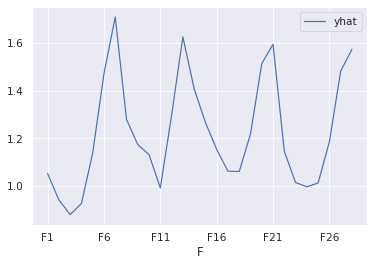

In [42]:
tmp_pd1 = df_levelx_forecast[df_levelx_forecast["id"].isin(["FOODS_1_001_CA_1"])]
tmp_pd1 = pd.melt(frame = tmp_pd1, 
                  id_vars = ['id'],
                  var_name = "F",
                  value_vars = [c for c in tmp_pd1.columns if "F" in c],
                  value_name = "yhat")
d = tmp_pd1.plot(kind="line", x="F", y="yhat")

In [43]:
SAMPLE_SUBMISSION = TRAIN_DATA_HOME + "sample_submission.csv"
sub_ids = pd.read_csv(SAMPLE_SUBMISSION)[['id']]
sub_ids = sub_ids[sub_ids.id.str.endswith("validation")]

In [44]:
for key, value in level_coef_dict.items():
    if (key <= MAX_LEVEL) and (key >= 1):
        predictions = yhat_df[yhat_df["level"] == key]
        df_levelx_forecast = predict_topdown(predictions, df_sale, value)
        print("Top-Down prediction for level %s, %s, items=%s into %s" % (key, value, predictions.shape[0], df_levelx_forecast.shape[0]))
        df_levelx_forecast["id"] = df_levelx_forecast["id"].astype(str) + "_validation"
        part1 = pd.merge(sub_ids, df_levelx_forecast, on="id", how="left")
        part2 = part1.copy()
        part2["id"] = part2["id"].str.replace("validation$", "evaluation")
        sub = pd.concat([part1, part2])
        MODE_LEVEL_PATH = MODELS_DIR + "/level_%d" % key
        if not os.path.exists(MODE_LEVEL_PATH):
            os.makedirs(MODE_LEVEL_PATH)
        sub.to_csv(MODE_LEVEL_PATH + "/submission.csv.gz", compression="gzip", index=False)

Top-Down prediction for level 5, ['dept_id'], items=7 into 30490
Top-Down prediction for level 4, ['cat_id'], items=3 into 30490
Top-Down prediction for level 3, ['store_id'], items=10 into 30490
Top-Down prediction for level 2, ['state_id'], items=3 into 30490


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Top-Down prediction for level 1, ['all'], items=1 into 30490
Top-Down prediction for level 7, ['state_id', 'dept_id'], items=21 into 30490
Top-Down prediction for level 9, ['store_id', 'dept_id'], items=70 into 30490
Top-Down prediction for level 6, ['state_id', 'cat_id'], items=9 into 30490
Top-Down prediction for level 8, ['store_id', 'cat_id'], items=30 into 30490


In [45]:
print(sub.shape)

(60980, 29)


In [46]:
sub.head()

id        F1        F2        F3        F4  \
0  HOBBIES_1_001_CA_1_validation  0.827428  0.804252  0.794037  0.776854   
1  HOBBIES_1_002_CA_1_validation  0.061291  0.059574  0.058818  0.057545   
2  HOBBIES_1_003_CA_1_validation  0.490328  0.476594  0.470540  0.460358   
3  HOBBIES_1_004_CA_1_validation  1.562920  1.519142  1.499847  1.467391   
4  HOBBIES_1_005_CA_1_validation  1.164529  1.131910  1.117533  1.093350   

         F5        F6        F7        F8        F9       F10       F11  \
0  0.936518  1.209231  1.203355  0.990687  0.919538  0.858091  0.840613   
1  0.069372  0.089573  0.089137  0.073384  0.068114  0.063562  0.062268   
2  0.554974  0.716581  0.713099  0.587074  0.544912  0.508499  0.498141   
3  1.768978  2.284102  2.273003  1.871297  1.736906  1.620839  1.587824   
4  1.318062  1.701880  1.693610  1.394300  1.294165  1.207684  1.183084   

        F12       F13       F14       F15       F16       F17       F18  \
0  0.970117  1.098812  0.856044  0.805398  0.798987  0.762795  0.789341   
1  0.071861  0.081393  0.063411  0.059659  0.059184  0.056503  0.058470   
2  0.574884  0.651148  0.507286  0.477273  0.473474  0.452027  0.467758   
3  1.832444  2.075533  1.616973  1.521308  1.509198  1.440835  1.490978   
4  1.365351  1.546476  1.204803  1.133523  1.124500  1.073563  1.110925   

        F19       F20       F21       F22       F23       F24       F25  \
0  0.915910  1.118652  1.063841  0.889272  0.848719  0.863774  0.891264   
1  0.067845  0.082863  0.078803  0.065872  0.062868  0.063983  0.066020   
2  0.542762  0.662905  0.630424  0.526976  0.502944  0.511866  0.528157   
3  1.730053  2.113009  2.009477  1.679736  1.603135  1.631574  1.683499   
4  1.289059  1.574399  1.497257  1.251568  1.194493  1.215682  1.254372   

        F26       F27       F28  
0  1.006392  1.213046  1.169718  
1  0.074548  0.089855  0.086646  
2  0.596380  0.718842  0.693166  
3  1.900963  2.291309  2.209468  
4  1.416404  1.707250  1.646270

In [47]:
sub.tail()

id        F1        F2        F3        F4  \
30485  FOODS_3_823_WI_3_evaluation  0.158088  0.151875  0.142780  0.143561   
30486  FOODS_3_824_WI_3_evaluation  0.237131  0.227813  0.214169  0.215342   
30487  FOODS_3_825_WI_3_evaluation  0.658698  0.632813  0.594915  0.598172   
30488  FOODS_3_826_WI_3_evaluation  0.685046  0.658126  0.618711  0.622098   
30489  FOODS_3_827_WI_3_evaluation  0.790438  0.759376  0.713898  0.717806   

             F5        F6        F7        F8        F9       F10       F11  \
30485  0.175882  0.238394  0.228933  0.233809  0.247905  0.201974  0.216683   
30486  0.263823  0.357590  0.343399  0.350713  0.371857  0.302961  0.325025   
30487  0.732842  0.993307  0.953885  0.974203  1.032936  0.841559  0.902848   
30488  0.762156  1.033039  0.992041  1.013171  1.074254  0.875222  0.938962   
30489  0.879411  1.191968  1.144663  1.169044  1.239523  1.009871  1.083417   

            F12       F13       F14       F15       F16       F17       F18  \
30485  0.260183  0.268730  0.257813  0.245228  0.202593  0.234496  0.238239   
30486  0.390274  0.403095  0.386719  0.367841  0.303889  0.351743  0.357358   
30487  1.084095  1.119709  1.074221  1.021782  0.844137  0.977065  0.992660   
30488  1.127459  1.164498  1.117189  1.062653  0.877903  1.016147  1.032367   
30489  1.300915  1.343651  1.289065  1.226138  1.012965  1.172478  1.191193   

            F19       F20       F21       F22       F23       F24       F25  \
30485  0.227960  0.316166  0.309387  0.213552  0.195890  0.174518  0.170834   
30486  0.341940  0.474248  0.464080  0.320327  0.293835  0.261776  0.256251   
30487  0.949832  1.317357  1.289111  0.889798  0.816208  0.727157  0.711809   
30488  0.987826  1.370051  1.340676  0.925390  0.848857  0.756243  0.740281   
30489  1.139799  1.580828  1.546933  1.067758  0.979450  0.872588  0.854170   

            F26       F27       F28  
30485  0.196259  0.235201  0.222431  
30486  0.294389  0.352801  0.333647  
30487  0.817747  0.980004  0.926796  
30488  0.850457  1.019204  0.963868  
30489  0.981296  1.176005  1.112155